In [2]:
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import xgboost as xgb

import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Input the data

## load dataset

In [3]:
folder_path = Path('../data/Shanghai_diabetes_datasets/clinical_info/csv')

if not os.path.exists(folder_path):
    raise FileNotFoundError(f"directory {folder_path} doesn't exist")

df1 = pd.read_csv(folder_path.joinpath('Shanghai_T1DM_Summary.csv'))
df2 = pd.read_csv(folder_path.joinpath('Shanghai_T2DM_Summary.csv'))

combined_df = pd.concat([df1, df2], ignore_index=True)
combined_df.head(9)

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),Hypoglycemia (yes/no),Comorbidities
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,non-drinker,T1DM,10.00,...,3.59,1.02,0.86,2.01,37.3,160,188.86,6.47,no,"hypertension, osteoporosis, thyroid nodule, pu..."
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,drinker,T1DM,26.00,...,4.78,2.2,0.93,3.28,66.8,109,342.57,6.05,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,drinker,T1DM,26.00,...,4.78,2.2,0.93,3.28,69.4,104,322.18,3.06,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,drinker,T1DM,26.00,...,3.49,1.82,0.84,1.83,63.7,115,342.34,6.21,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,non-drinker,T1DM,0.08,...,5.61,1.14,1.08,3.95,49.6,174,93.39,1.85,yes,"leucopenia, hypokalemia, hepatic dysfunction"
5,1004_0_20210425,1,67,1.55,47,19.56,0.0,non-drinker,T1DM,12.00,...,4.57,0.91,1.27,2.76,45.2,127,240.61,3.98,yes,"hypocalcemia, thyroid nodule, osteoporosis"
6,1005_0_20210522,2,58,1.70,50,17.30,22.5,non-drinker,T1DM,16.00,...,4.05,0.46,1.57,2.12,75.4,98,205.48,3.96,yes,"thyroid nodule, prostatic hyperplasia, osteopo..."
7,1006_0_20210114,2,57,1.61,53,20.52,0.0,non-drinker,T1DM,7.00,...,4.44,0.68,1.97,2.57,74.0,97,247.00,6.40,yes,none
8,1006_1_20210209,2,57,1.61,52,20.18,0.0,non-drinker,T1DM,7.00,...,5.12,0.64,1.88,2.93,82.0,91,257.00,6.40,yes,none


## handling missing values

In [6]:
combined_df.replace('/', pd.NA, inplace=True)  # convert / to null

cols_to_fill = [
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
    '2-hour Postprandial Plasma Glucose (mg/dl)', 'Fasting C-peptide (nmol/L)',
    '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
    'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
    'High-Density Lipoprotein Cholesterol (mmol/L)', 'Low-Density Lipoprotein Cholesterol (mmol/L)',
    'Creatinine (umol/L)', 'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
    'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]

for col in cols_to_fill:
    if col in combined_df.columns:
        combined_df[col] = pd.to_numeric(combined_df[col].astype(str).str.strip(), errors='coerce')

combined_df[cols_to_fill] = combined_df[cols_to_fill].fillna(combined_df[cols_to_fill].median())

combined_df.to_csv('finish_data.csv', index=False)

## analyse data

In [4]:
combined_df.describe()

,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Duration of Diabetes (years),Fasting Plasma Glucose (mg/dl),2-hour Postprandial Plasma Glucose (mg/dl),Fasting C-peptide (nmol/L),...,HbA1c (mmol/mol),Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L)
count,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,...,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000
mean,1.544000,60.136000,1.655120,65.216000,23.72184,4.533600,9.059680,168.346080,263.586240,0.400936,...,75.14400,24.428000,4.785280,1.670960,1.159600,3.072320,63.012000,116.76000,320.734320,5.831440
std,0.500065,13.547017,0.094627,11.984253,3.46806,13.181143,8.399958,65.815955,84.357438,0.264888,...,26.50919,8.869616,0.990184,0.966817,0.352924,0.894042,18.655301,40.02608,89.379685,1.698329
min,1.000000,22.000000,1.420000,35.000000,13.67000,0.000000,0.010000,55.800000,72.540000,0.007000,...,23.00000,7.100000,2.510000,0.460000,0.690000,0.980000,22.600000,34.00000,93.390000,1.810000
25%,1.000000,52.000000,1.600000,56.000000,21.89000,0.000000,1.000000,124.920000,212.580000,0.230000,...,55.00000,19.500000,4.270000,1.080000,0.930000,2.520000,52.400000,99.00000,262.400000,5.210000
50%,2.000000,62.000000,1.650000,65.000000,23.44000,0.000000,7.000000,158.400000,256.320000,0.370000,...,68.00000,22.400000,4.690000,1.540000,1.080000,3.080000,62.800000,108.00000,317.030000,5.600000
75%,2.000000,68.000000,1.720000,72.000000,25.30000,0.000000,15.000000,194.400000,304.200000,0.500000,...,93.00000,28.200000,5.310000,1.810000,1.290000,3.690000,70.400000,126.00000,355.960000,6.400000
max,2.000000,97.000000,1.900000,100.000000,36.73000,80.000000,40.000000,432.000000,610.380000,1.240000,...,166.00000,71.100000,7.790000,7.650000,2.560000,5.270000,136.100000,286.00000,563.960000,15.580000


## handling duplicates

In [5]:
duplicate_rows_data = combined_df[combined_df.duplicated()]
print('duplicate_rows_data', duplicate_rows_data)

duplicate_rows_data Empty DataFrame
Columns: [Patient Number, Gender (Female=1, Male=2), Age (years), Height (m), Weight (kg), BMI (kg/m2), Smoking History (pack year), Alcohol Drinking History (drinker/non-drinker), Type of Diabetes, Duration of Diabetes (years), Acute Diabetic Complications, Diabetic Macrovascular  Complications, Diabetic Microvascular Complications, Comorbidities, Hypoglycemic Agents, Other Agents, Fasting Plasma Glucose (mg/dl), 2-hour Postprandial Plasma Glucose (mg/dl), Fasting C-peptide (nmol/L), 2-hour Postprandial C-peptide (nmol/L), Fasting Insulin (pmol/L), 2-hour Postprandial Insulin (pmol/L), HbA1c (mmol/mol), Glycated Albumin (%), Total Cholesterol (mmol/L), Triglyceride (mmol/L), High-Density Lipoprotein Cholesterol (mmol/L), Low-Density Lipoprotein Cholesterol (mmol/L), Creatinine (umol/L), Estimated Glomerular Filtration Rate  (ml/min/1.73m2), Uric Acid (mmol/L), Blood Urea Nitrogen (mmol/L), Hypoglycemia (yes/no)]
Index: []

[0 rows x 33 columns]


## uniqueness

In [6]:
for column in combined_df.columns:
    unique_value = len(combined_df[column].unique())
    print(f'{column}: {unique_value} quantity unique value')

Patient Number: 125 quantity unique value
Gender (Female=1, Male=2): 2 quantity unique value
Age (years): 45 quantity unique value
Height (m): 35 quantity unique value
Weight (kg): 42 quantity unique value
BMI (kg/m2): 100 quantity unique value
Smoking History (pack year): 15 quantity unique value
Alcohol Drinking History (drinker/non-drinker): 2 quantity unique value
Type of Diabetes: 2 quantity unique value
Duration of Diabetes (years): 36 quantity unique value
Acute Diabetic Complications: 2 quantity unique value
Diabetic Macrovascular  Complications: 8 quantity unique value
Diabetic Microvascular Complications: 8 quantity unique value
Comorbidities: 58 quantity unique value
Hypoglycemic Agents: 78 quantity unique value
Other Agents: 70 quantity unique value
Fasting Plasma Glucose (mg/dl): 81 quantity unique value
2-hour Postprandial Plasma Glucose (mg/dl): 96 quantity unique value
Fasting C-peptide (nmol/L): 62 quantity unique value
2-hour Postprandial C-peptide (nmol/L): 59 quanti

# Visualisation

## objects types

## Histogram for types of diabetes

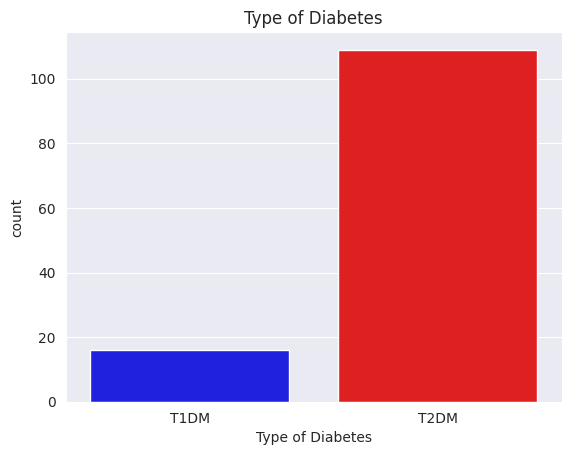

In [7]:
sns.countplot(x='Type of Diabetes', data=combined_df, hue='Type of Diabetes', palette=['blue', 'red'])
plt.title('Type of Diabetes')
plt.show()

## Histogram for types of diabetes

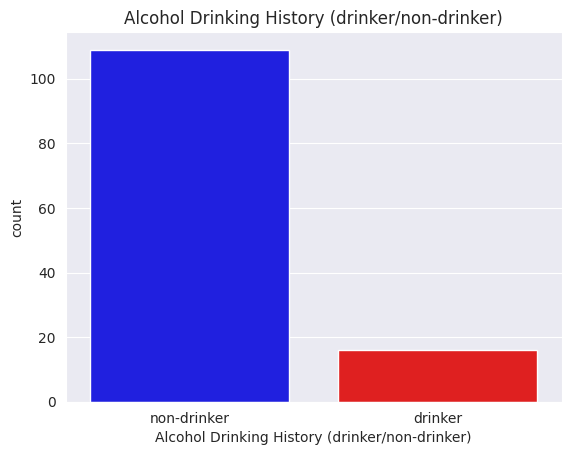

In [8]:
sns.countplot(x='Alcohol Drinking History (drinker/non-drinker)', hue='Alcohol Drinking History (drinker/non-drinker)',
              palette=['blue', 'red'], data=combined_df)
plt.title('Alcohol Drinking History (drinker/non-drinker)')
plt.show()

## Histogram for Acute Diabetic Complications

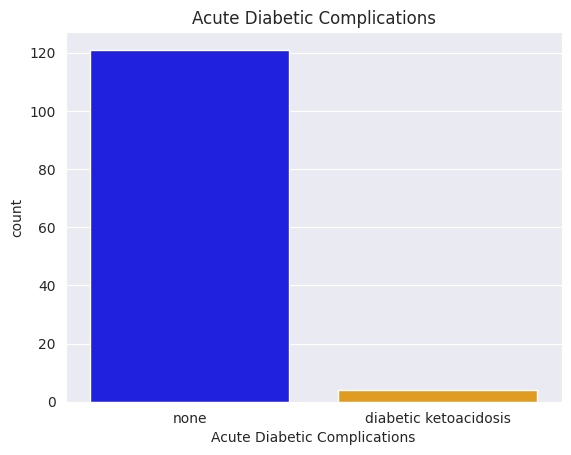

In [9]:
sns.countplot(x='Acute Diabetic Complications', hue='Acute Diabetic Complications', data=combined_df,
              palette=['blue', 'orange'])
plt.title('Acute Diabetic Complications')
plt.show()
# peripheral arterial list_of_categories, cerebrovascular list_of_categories

## Diabetic Macrovascular Complications

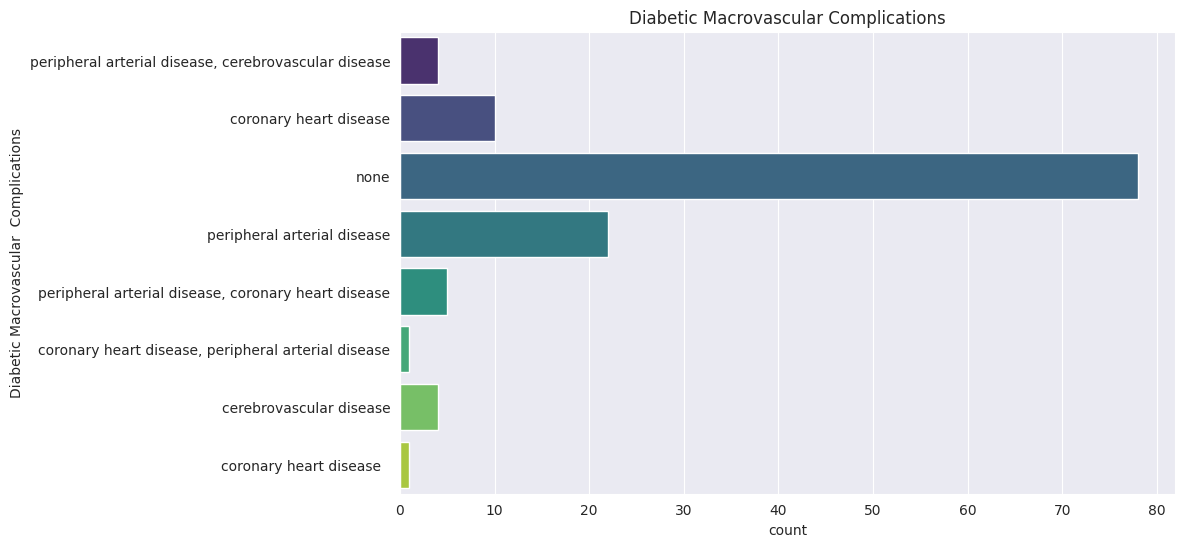

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Diabetic Macrovascular  Complications', hue='Diabetic Macrovascular  Complications', data=combined_df,
              palette='viridis')
plt.title('Diabetic Macrovascular Complications')
plt.show()

## Diabetic Microvascular Complications

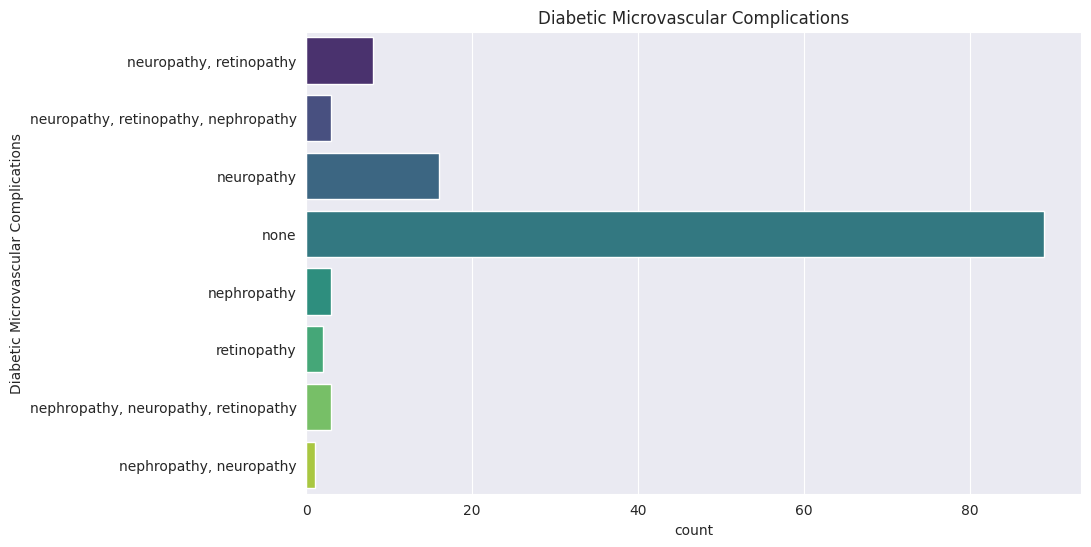

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Diabetic Microvascular Complications', hue='Diabetic Microvascular Complications', data=combined_df,
              palette='viridis')
plt.title('Diabetic Microvascular Complications')
plt.show()

In [12]:
combined_df['Diabetic Microvascular Complications'].value_counts()

Diabetic Microvascular Complications
none                                    89
neuropathy                              16
neuropathy, retinopathy                  8
neuropathy, retinopathy, nephropathy     3
nephropathy                              3
nephropathy, neuropathy, retinopathy     3
retinopathy                              2
nephropathy, neuropathy                  1
Name: count, dtype: int64

## Comorbidities

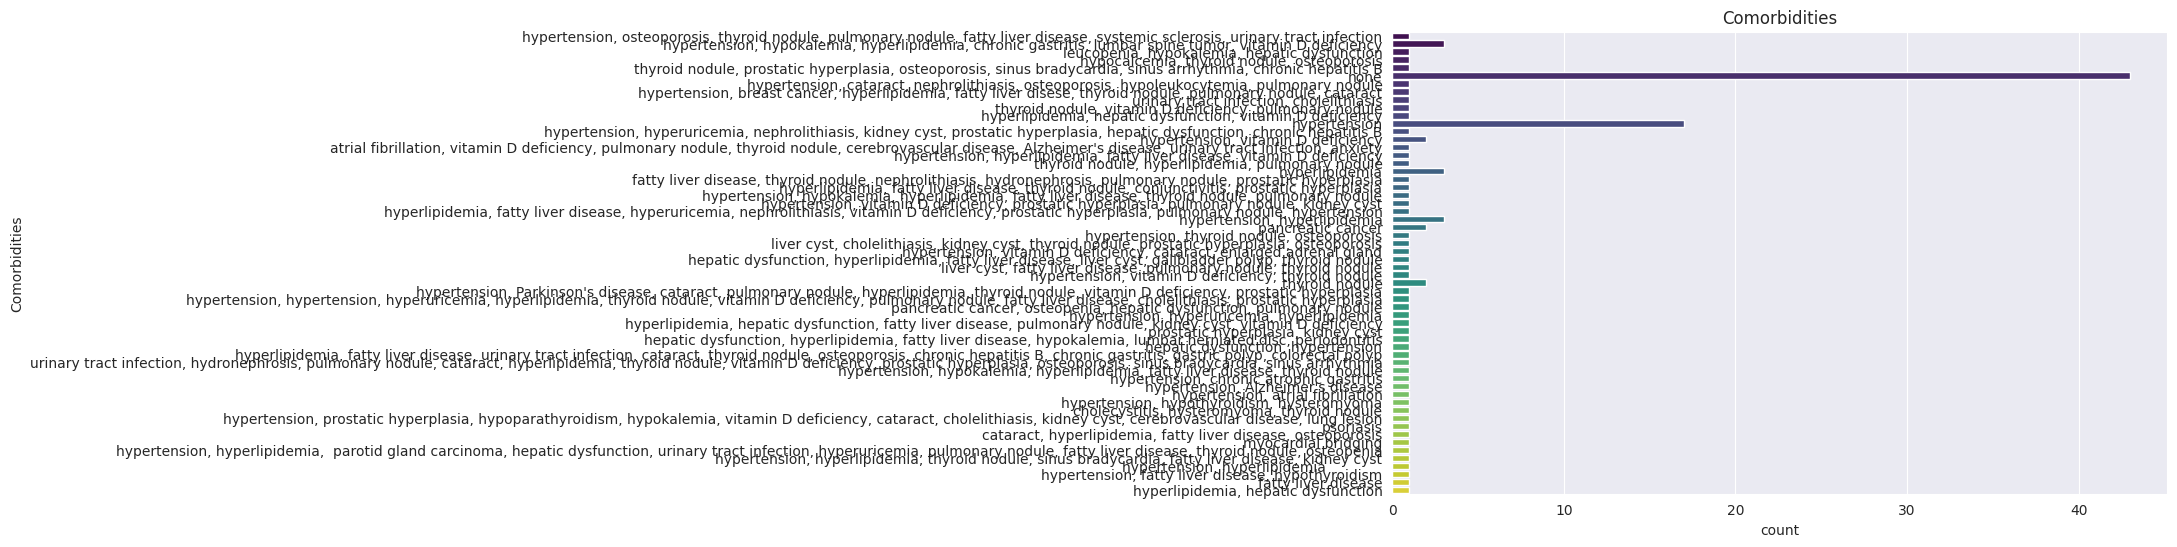

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Comorbidities', hue='Comorbidities', data=combined_df,
              palette='viridis')
plt.title('Comorbidities')
plt.show()

## Hypoglycemic Agents

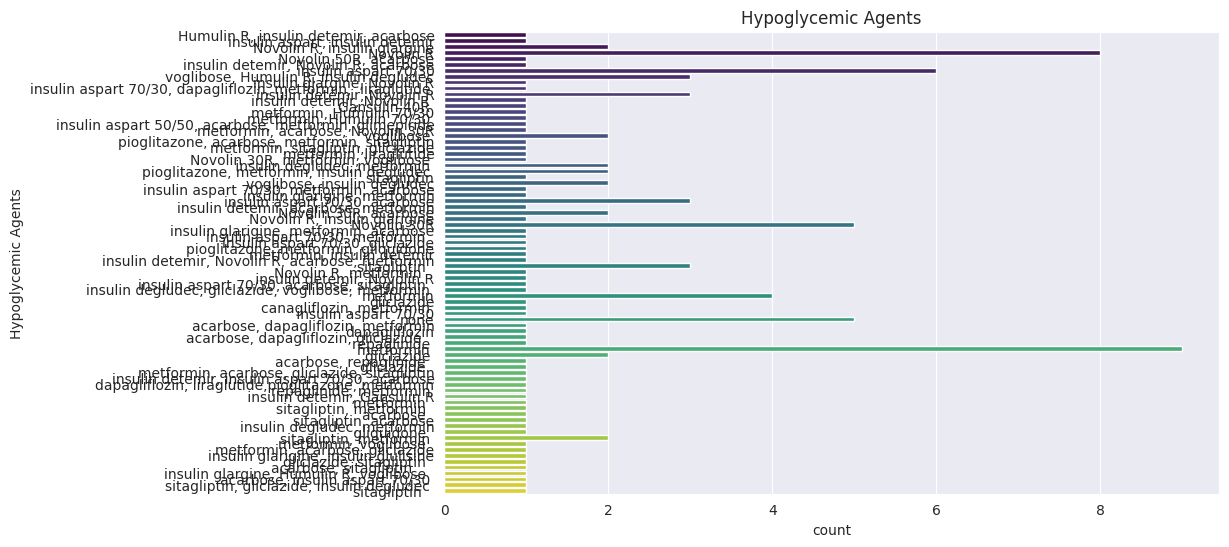

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Hypoglycemic Agents', hue='Hypoglycemic Agents', data=combined_df,
              palette='viridis')
plt.title('Hypoglycemic Agents')
plt.show()

## Other Agents

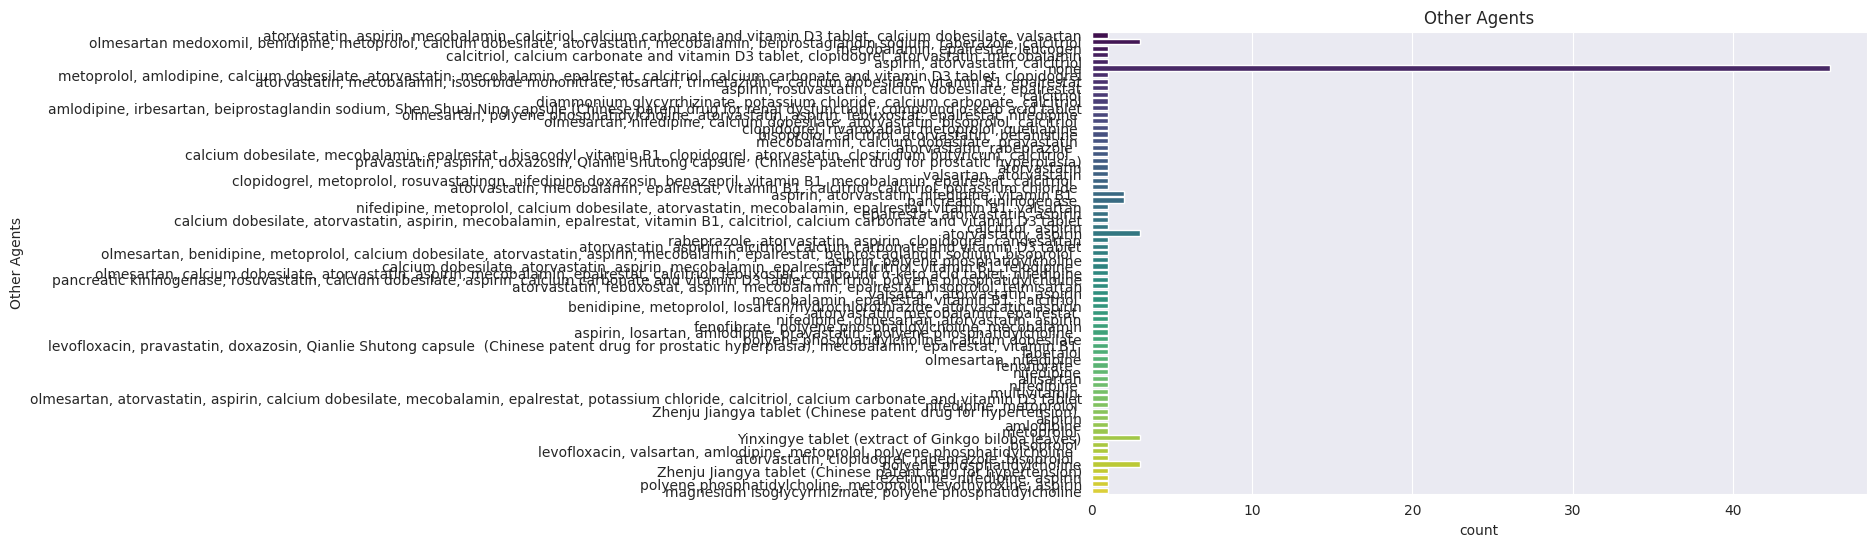

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Other Agents', hue='Other Agents', data=combined_df,
              palette='viridis')
plt.title('Other Agents')
plt.show()

## Hypoglycemia

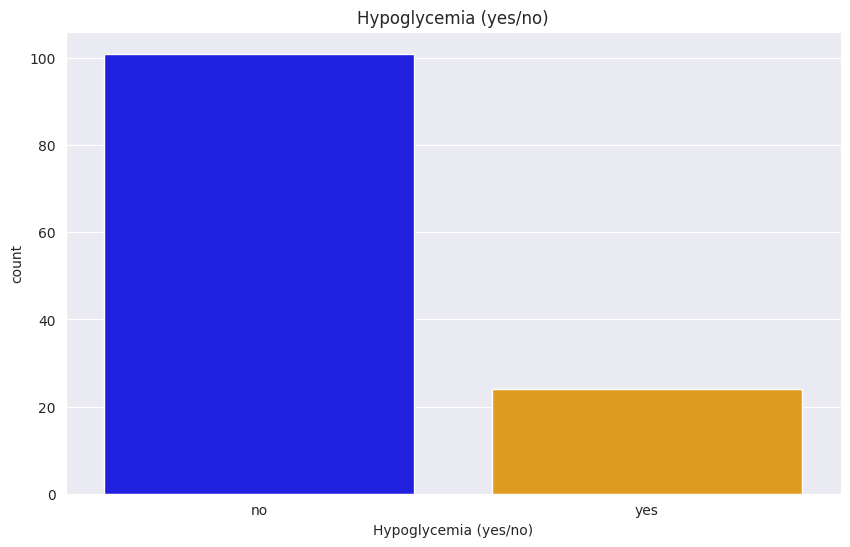

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Hypoglycemia (yes/no)', hue='Hypoglycemia (yes/no)', data=combined_df,
              palette=['blue', 'orange'])
plt.title('Hypoglycemia (yes/no)')
plt.show()

## Gender (Female=1, Male=2)

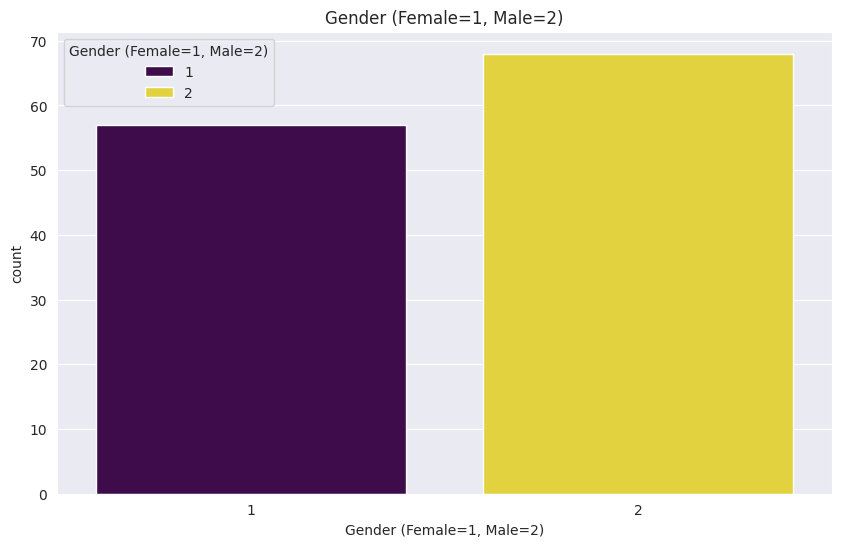

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender (Female=1, Male=2)', hue='Gender (Female=1, Male=2)', data=combined_df, palette='viridis')
plt.title('Gender (Female=1, Male=2)')
plt.show()

## number types

array([[<Axes: title={'center': 'Age (years)'}>,
        <Axes: title={'center': 'Height (m)'}>,
        <Axes: title={'center': 'Weight (kg)'}>,
        <Axes: title={'center': 'BMI (kg/m2)'}>,
        <Axes: title={'center': 'Smoking History (pack year)'}>],
       [<Axes: title={'center': 'Duration of Diabetes (years)'}>,
        <Axes: title={'center': 'Fasting Plasma Glucose (mg/dl)'}>,
        <Axes: title={'center': '2-hour Postprandial Plasma Glucose (mg/dl)'}>,
        <Axes: title={'center': 'Fasting C-peptide (nmol/L)'}>,
        <Axes: title={'center': '2-hour Postprandial C-peptide (nmol/L)'}>],
       [<Axes: title={'center': 'Fasting Insulin (pmol/L)'}>,
        <Axes: title={'center': '2-hour Postprandial Insulin (pmol/L)'}>,
        <Axes: title={'center': 'HbA1c (mmol/mol)'}>,
        <Axes: title={'center': 'Glycated Albumin (%)'}>,
        <Axes: title={'center': 'Total Cholesterol (mmol/L)'}>],
       [<Axes: title={'center': 'Triglyceride (mmol/L)'}>,
        <Axe

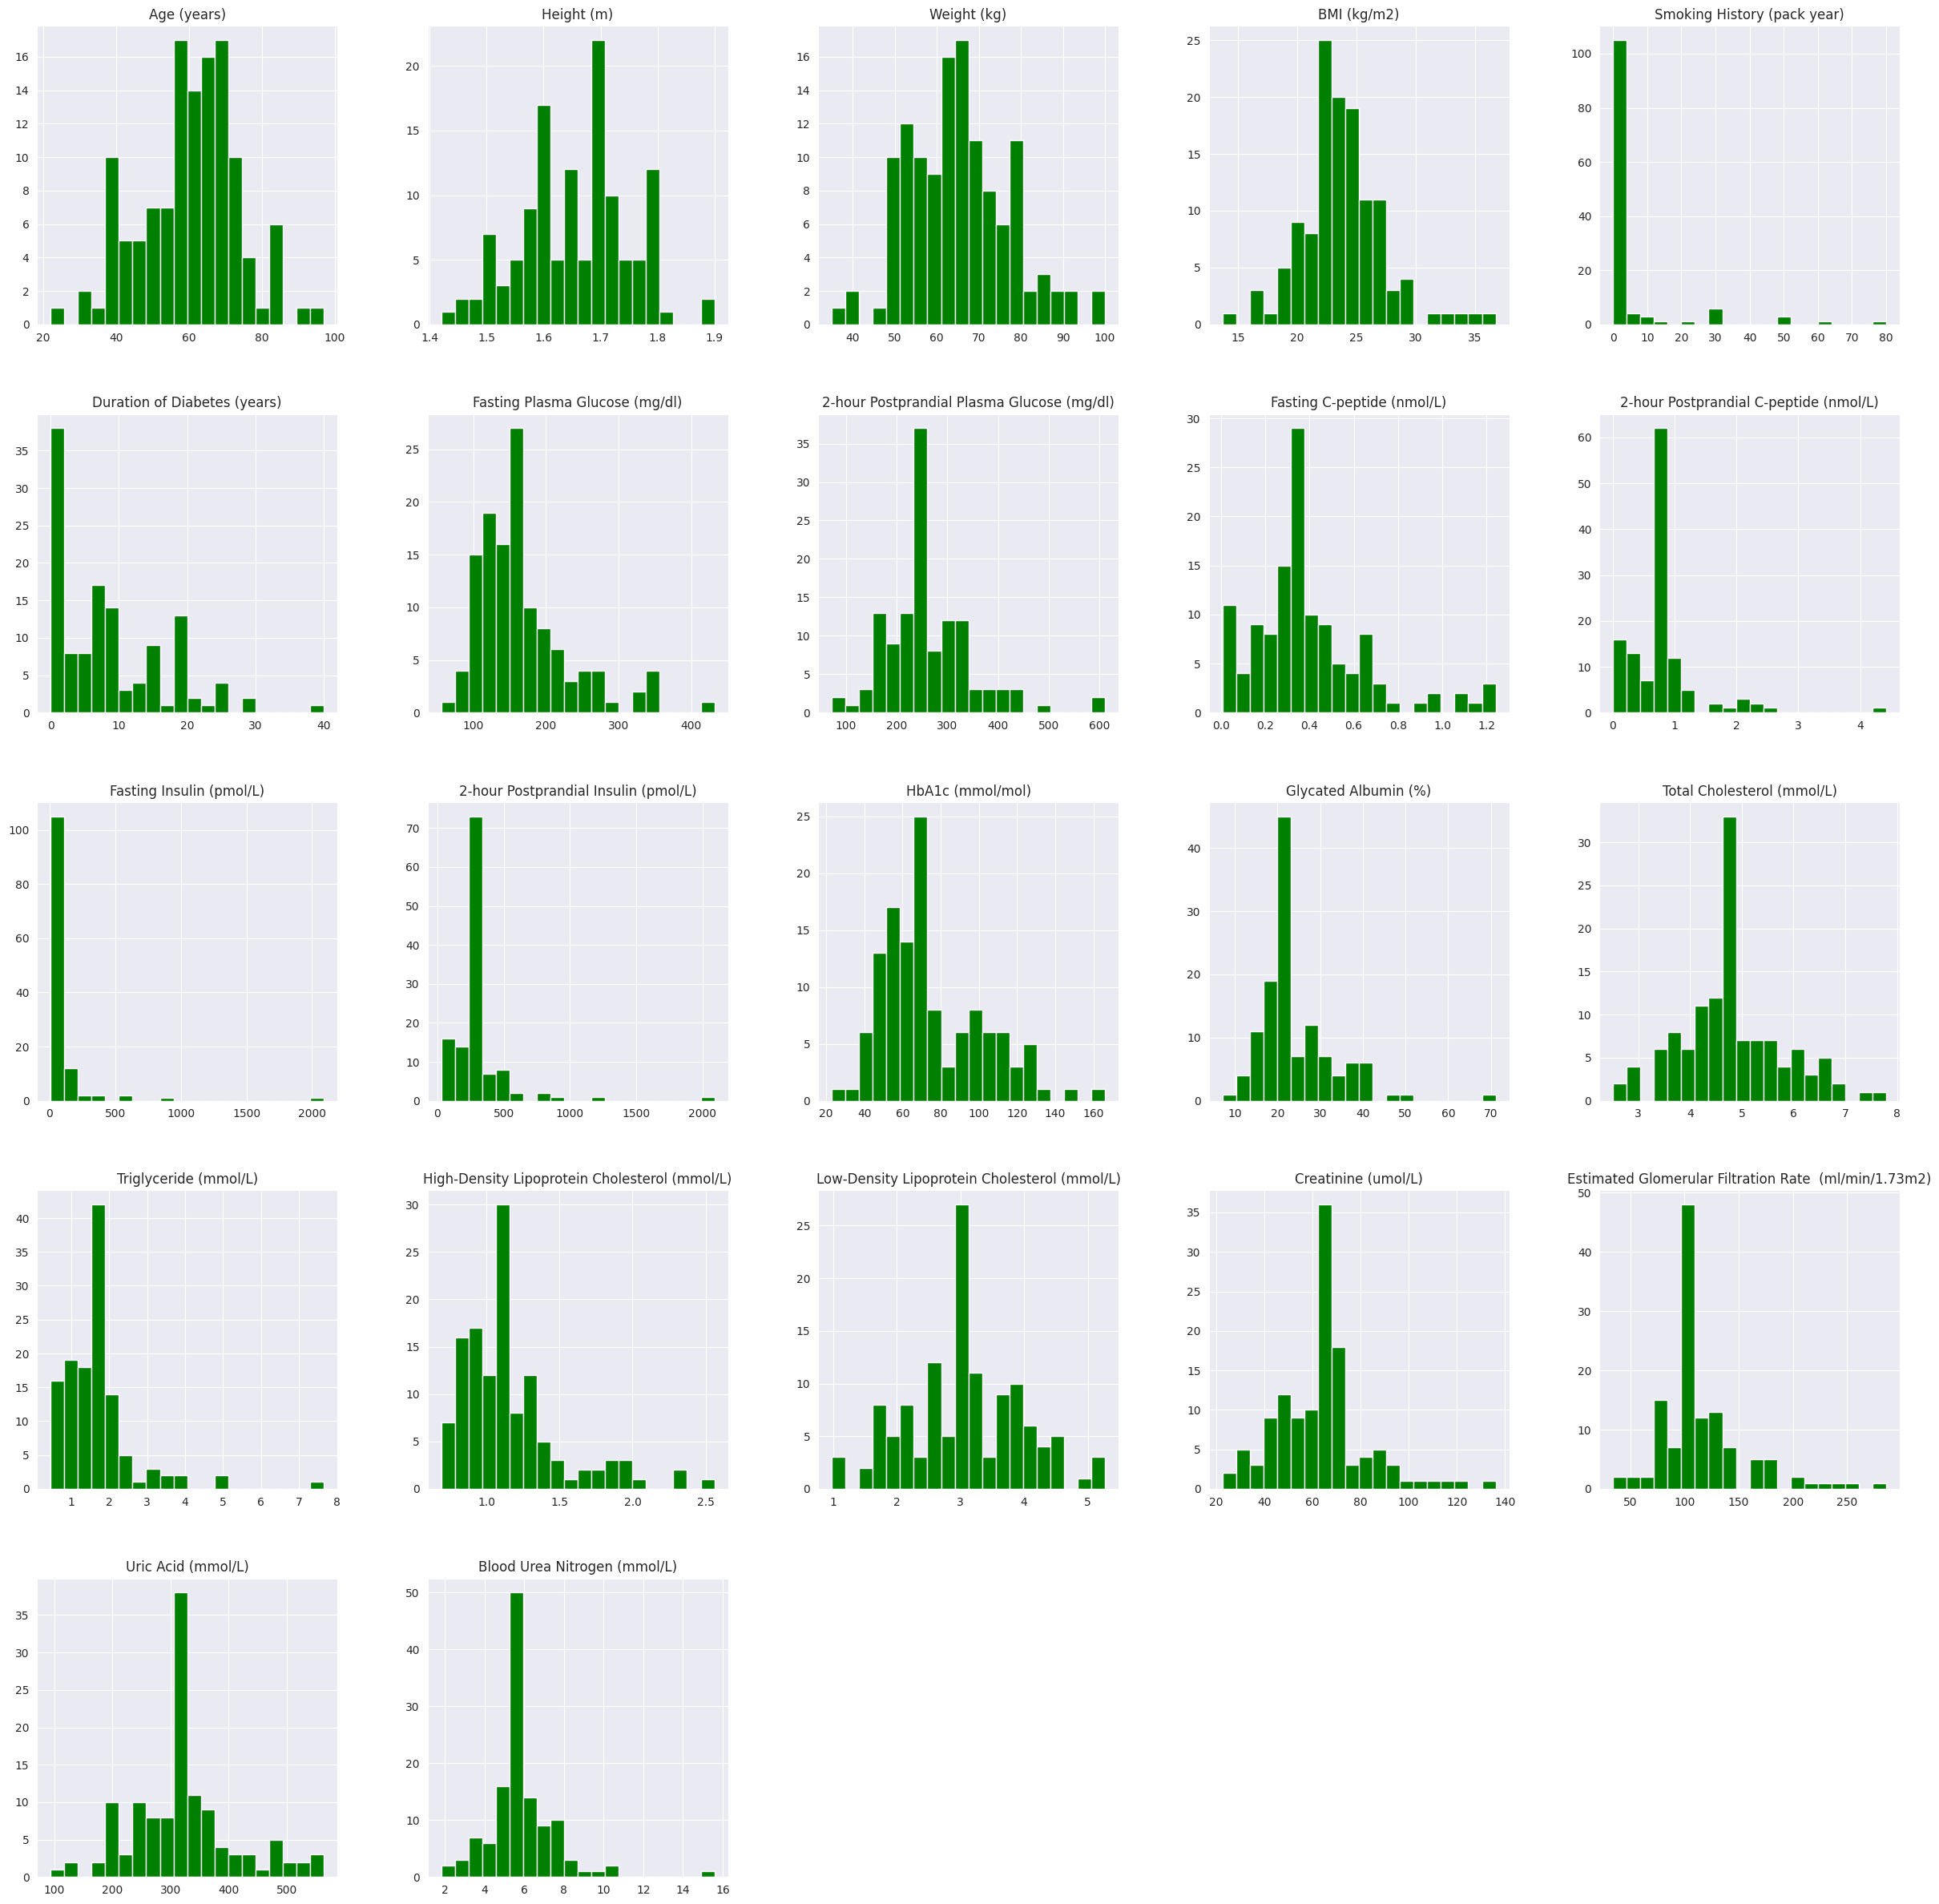

In [18]:
cols_to_fill = [
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
    '2-hour Postprandial Plasma Glucose (mg/dl)', 'Fasting C-peptide (nmol/L)',
    '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
    'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
    'High-Density Lipoprotein Cholesterol (mmol/L)', 'Low-Density Lipoprotein Cholesterol (mmol/L)',
    'Creatinine (umol/L)', 'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
    'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]
num_types_combined_df = combined_df[cols_to_fill]
num_types_combined_df.hist(bins=20, figsize=(30, 30), color='green')

# Preparing data

In [7]:
cols_to_fill = [
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
    '2-hour Postprandial Plasma Glucose (mg/dl)', 'Fasting C-peptide (nmol/L)',
    '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
    'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
    'High-Density Lipoprotein Cholesterol (mmol/L)', 'Low-Density Lipoprotein Cholesterol (mmol/L)',
    'Creatinine (umol/L)', 'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
    'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]

## emissions

In [20]:
for col in cols_to_fill:
    q1 = combined_df[col].quantile(0.25)
    q3 = combined_df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = combined_df[(combined_df[col] < lower) | (combined_df[col] > upper)]
    print(f'{col}: {len(outliers)} emissions')

Age (years): 2 emissions
Height (m): 1 emissions
Weight (kg): 2 emissions
BMI (kg/m2): 7 emissions
Smoking History (pack year): 22 emissions
Duration of Diabetes (years): 1 emissions
Fasting Plasma Glucose (mg/dl): 7 emissions
2-hour Postprandial Plasma Glucose (mg/dl): 5 emissions
Fasting C-peptide (nmol/L): 8 emissions
2-hour Postprandial C-peptide (nmol/L): 24 emissions
Fasting Insulin (pmol/L): 12 emissions
2-hour Postprandial Insulin (pmol/L): 62 emissions
HbA1c (mmol/mol): 1 emissions
Glycated Albumin (%): 5 emissions
Total Cholesterol (mmol/L): 5 emissions
Triglyceride (mmol/L): 10 emissions
High-Density Lipoprotein Cholesterol (mmol/L): 10 emissions
Low-Density Lipoprotein Cholesterol (mmol/L): 0 emissions
Creatinine (umol/L): 7 emissions
Estimated Glomerular Filtration Rate  (ml/min/1.73m2): 17 emissions
Uric Acid (mmol/L): 7 emissions
Blood Urea Nitrogen (mmol/L): 14 emissions


## correction emissions

In [8]:
combined_df = combined_df[combined_df['Fasting Insulin (pmol/L)'] < 700]
combined_df = combined_df[combined_df['2-hour Postprandial Insulin (pmol/L)'] < 800]

In [5]:
combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),Hypoglycemia (yes/no),Comorbidities
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,non-drinker,T1DM,10.00,...,3.59,1.02,0.86,2.01,37.3,160.0,188.86,6.47,no,"hypertension, osteoporosis, thyroid nodule, pu..."
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,drinker,T1DM,26.00,...,4.78,2.20,0.93,3.28,66.8,109.0,342.57,6.05,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,drinker,T1DM,26.00,...,4.78,2.20,0.93,3.28,69.4,104.0,322.18,3.06,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,drinker,T1DM,26.00,...,3.49,1.82,0.84,1.83,63.7,115.0,342.34,6.21,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,non-drinker,T1DM,0.08,...,5.61,1.14,1.08,3.95,49.6,174.0,93.39,1.85,yes,"leucopenia, hypokalemia, hepatic dysfunction"


## drop unused columns

In [9]:
combined_df = combined_df.drop(columns=[
    'Hypoglycemic Agents', 'Comorbidities', 'Other Agents', 'Diabetic Macrovascular  Complications',
    'Diabetic Microvascular Complications', 'Acute Diabetic Complications'])

In [7]:
combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),Hypoglycemia (yes/no)
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,non-drinker,T1DM,10.00,...,40.7,3.59,1.02,0.86,2.01,37.3,160.0,188.86,6.47,no
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,drinker,T1DM,26.00,...,19.6,4.78,2.20,0.93,3.28,66.8,109.0,342.57,6.05,yes
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,drinker,T1DM,26.00,...,19.6,4.78,2.20,0.93,3.28,69.4,104.0,322.18,3.06,yes
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,drinker,T1DM,26.00,...,25.1,3.49,1.82,0.84,1.83,63.7,115.0,342.34,6.21,yes
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,non-drinker,T1DM,0.08,...,46.6,5.61,1.14,1.08,3.95,49.6,174.0,93.39,1.85,yes


## encoding columns Alcohol Drinking History (drinker/non-drinker) and Hypoglycemia (yes/no)

Hypoglycemia (yes/no) -> (yes 1 / no 0)
Alcohol Drinking History (drinker/non-drinker) -> (yes 0 / no 1)

In [10]:
label_encoder = preprocessing.LabelEncoder()

for col_to_encode in ['Alcohol Drinking History (drinker/non-drinker)', 'Hypoglycemia (yes/no)']:
    combined_df[col_to_encode] = label_encoder.fit_transform(combined_df[col_to_encode])

combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),Hypoglycemia (yes/no)
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,T1DM,10.00,...,40.7,3.59,1.02,0.86,2.01,37.3,160.0,188.86,6.47,0
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,T1DM,26.00,...,19.6,4.78,2.20,0.93,3.28,66.8,109.0,342.57,6.05,1
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,T1DM,26.00,...,19.6,4.78,2.20,0.93,3.28,69.4,104.0,322.18,3.06,1
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,T1DM,26.00,...,25.1,3.49,1.82,0.84,1.83,63.7,115.0,342.34,6.21,1
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,T1DM,0.08,...,46.6,5.61,1.14,1.08,3.95,49.6,174.0,93.39,1.85,1


## rename Hypoglycemia (yes/no)

In [11]:
combined_df[f'has_hypoglycemia'] = combined_df['Hypoglycemia (yes/no)']

In [12]:
df = combined_df.drop(columns=['Hypoglycemia (yes/no)'])
df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),has_hypoglycemia
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,T1DM,10.00,...,40.7,3.59,1.02,0.86,2.01,37.3,160.0,188.86,6.47,0
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,T1DM,26.00,...,19.6,4.78,2.20,0.93,3.28,66.8,109.0,342.57,6.05,1
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,T1DM,26.00,...,19.6,4.78,2.20,0.93,3.28,69.4,104.0,322.18,3.06,1
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,T1DM,26.00,...,25.1,3.49,1.82,0.84,1.83,63.7,115.0,342.34,6.21,1
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,T1DM,0.08,...,46.6,5.61,1.14,1.08,3.95,49.6,174.0,93.39,1.85,1


In [12]:
df.columns

Index(['Patient Number', 'Gender (Female=1, Male=2)', 'Age (years)',
       'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
       'Smoking History (pack year)',
       'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
       'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
       '2-hour Postprandial Plasma Glucose (mg/dl)',
       'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)',
       'Fasting Insulin (pmol/L)', '2-hour Postprandial Insulin (pmol/L)',
       'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
       'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
       'High-Density Lipoprotein Cholesterol (mmol/L)',
       'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
       'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
       'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)',
       'has_hypoglycemia'],
      dtype='object')

# Visualisation with new data

## Visualisation int values

array([[<Axes: title={'center': 'Age (years)'}>,
        <Axes: title={'center': 'Height (m)'}>,
        <Axes: title={'center': 'Weight (kg)'}>,
        <Axes: title={'center': 'BMI (kg/m2)'}>,
        <Axes: title={'center': 'Smoking History (pack year)'}>],
       [<Axes: title={'center': 'Duration of Diabetes (years)'}>,
        <Axes: title={'center': 'Fasting Plasma Glucose (mg/dl)'}>,
        <Axes: title={'center': '2-hour Postprandial Plasma Glucose (mg/dl)'}>,
        <Axes: title={'center': 'Fasting C-peptide (nmol/L)'}>,
        <Axes: title={'center': '2-hour Postprandial C-peptide (nmol/L)'}>],
       [<Axes: title={'center': 'Fasting Insulin (pmol/L)'}>,
        <Axes: title={'center': '2-hour Postprandial Insulin (pmol/L)'}>,
        <Axes: title={'center': 'HbA1c (mmol/mol)'}>,
        <Axes: title={'center': 'Glycated Albumin (%)'}>,
        <Axes: title={'center': 'Total Cholesterol (mmol/L)'}>],
       [<Axes: title={'center': 'Triglyceride (mmol/L)'}>,
        <Axe

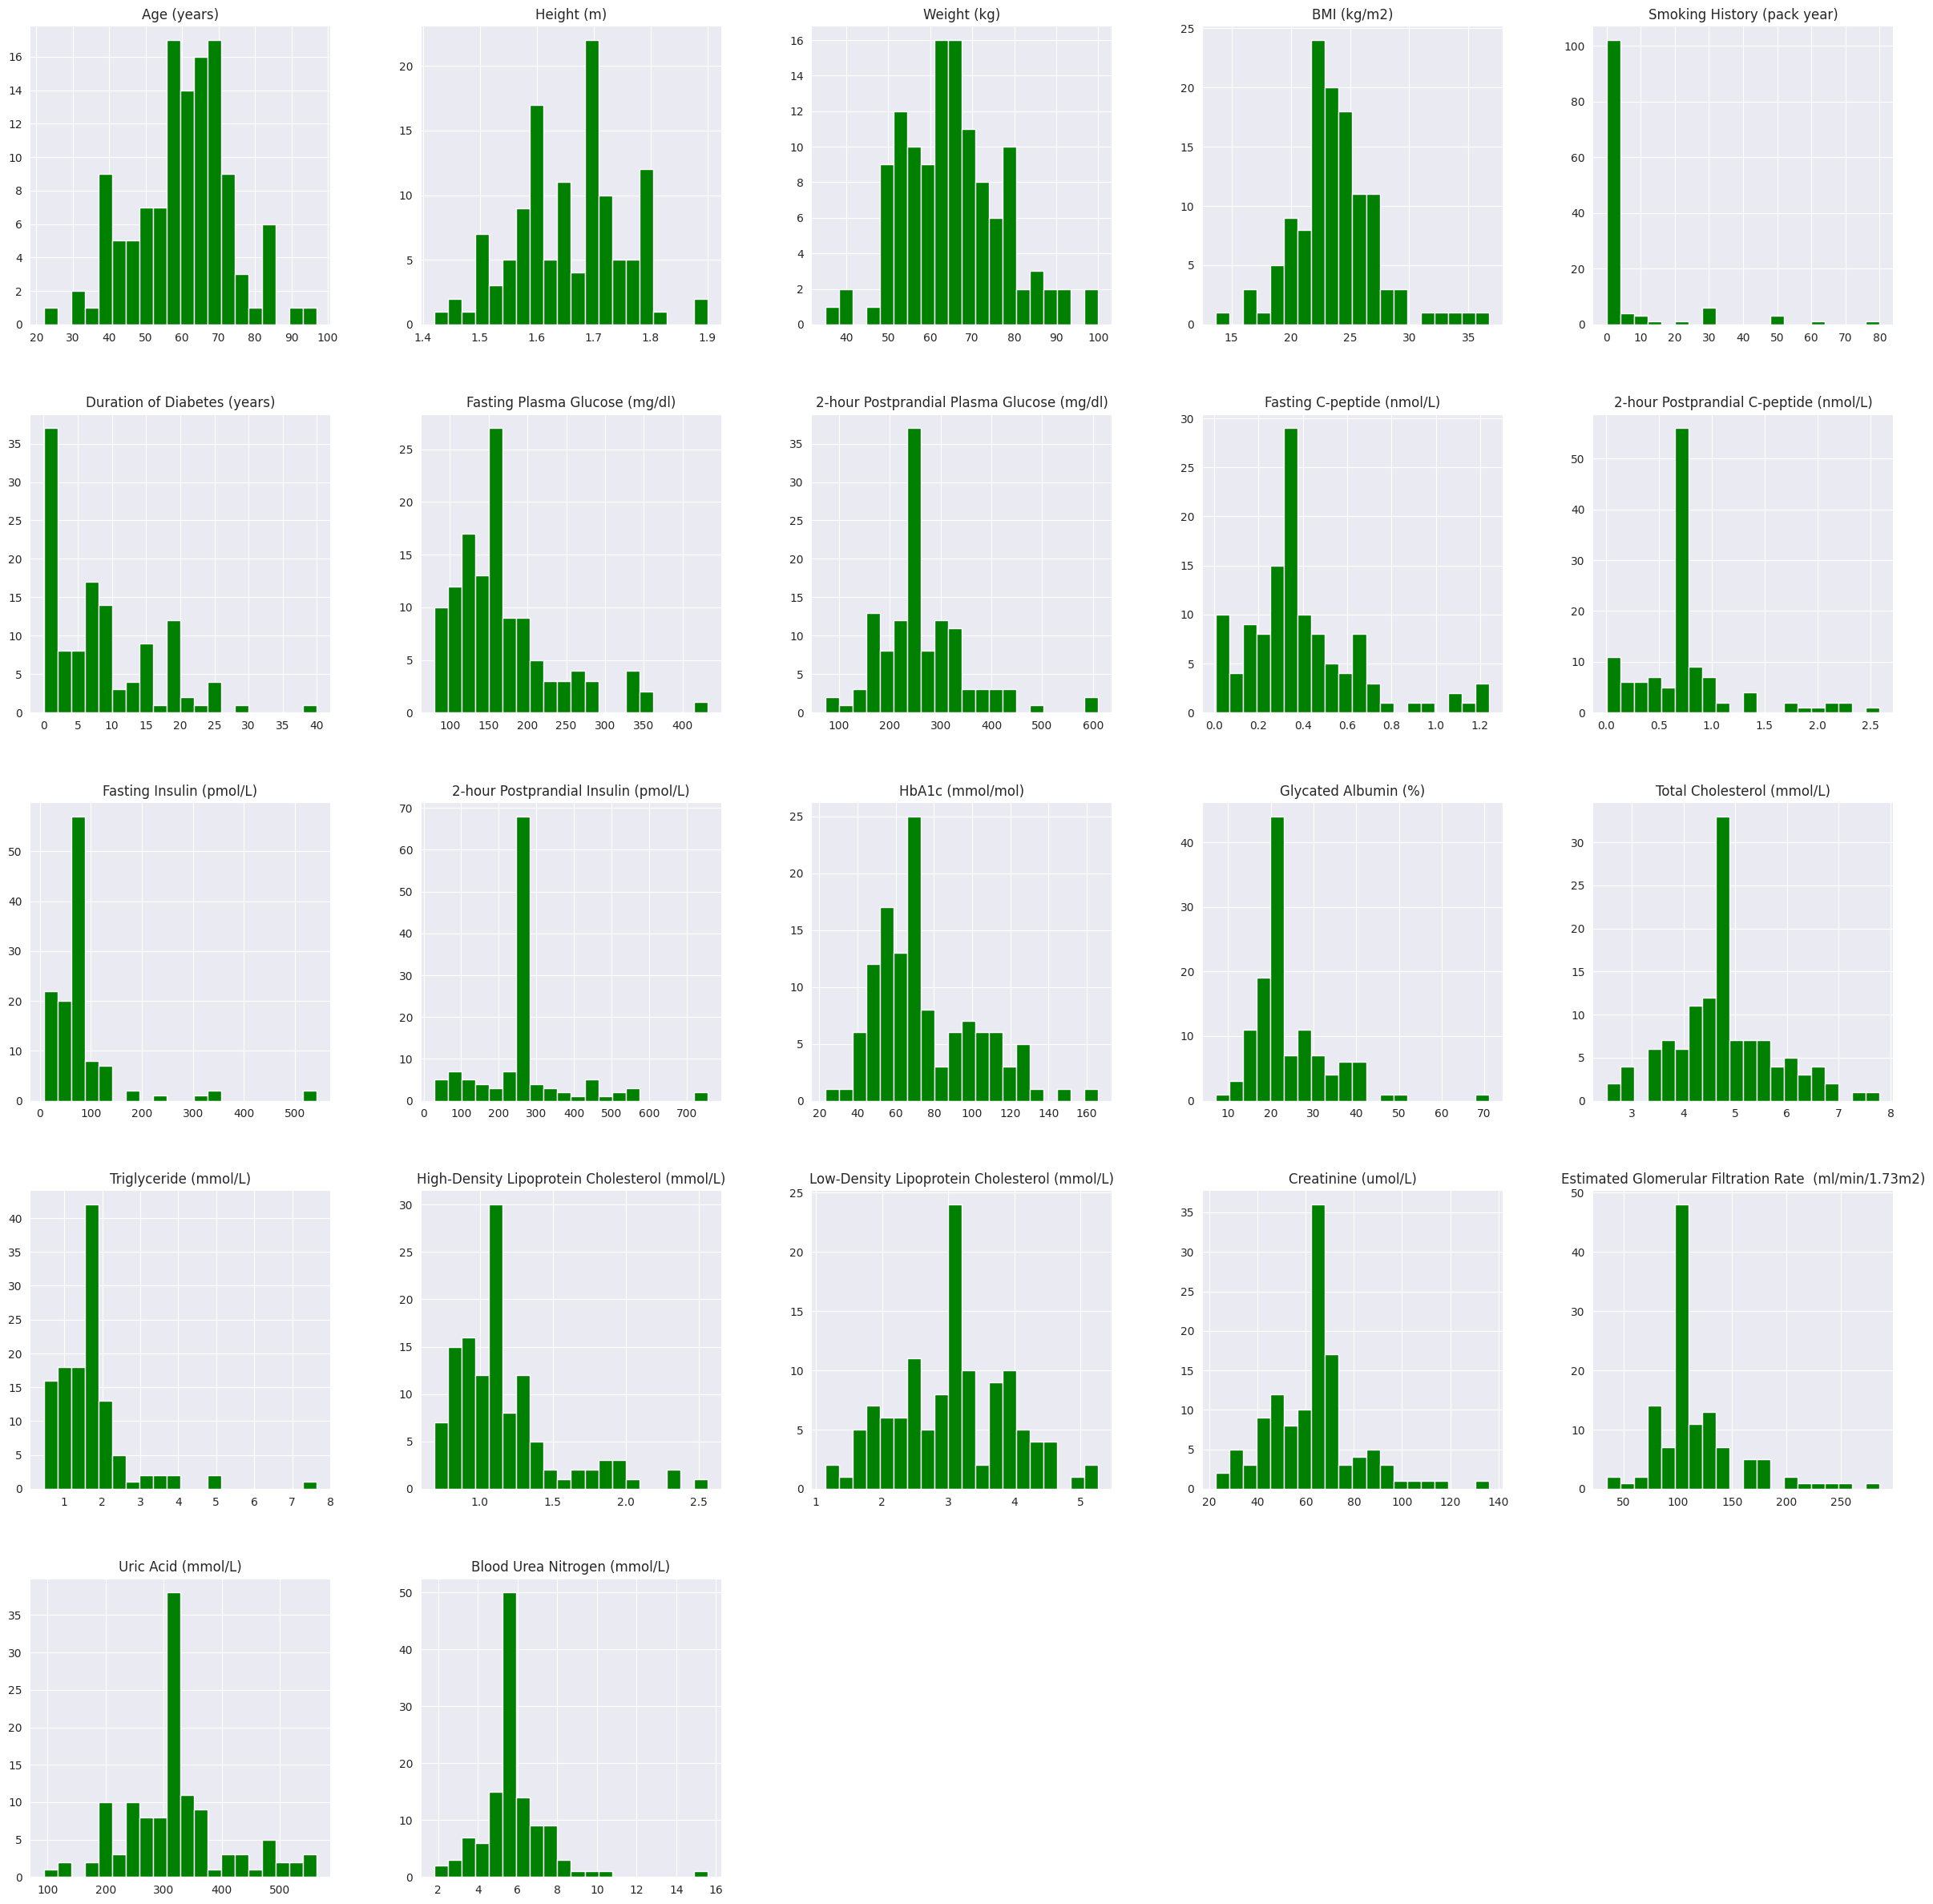

In [13]:
num_cols_to_fill = [
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)', '2-hour Postprandial Plasma Glucose (mg/dl)',
    'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)', 'Total Cholesterol (mmol/L)',
    'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)',
    'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
    'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]
num_types_df = df[num_cols_to_fill]
num_types_df.hist(bins=20, figsize=(30, 30), color='green')

In [30]:
def check(df, list_cols):
    for col in df.columns.tolist():
        if col not in list_cols:
            print(col)


check(df,
      ['Gender (Female=1, Male=2)', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)', 'Age (years)',
       'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
       'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)', '2-hour Postprandial Plasma Glucose (mg/dl)',
       'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
       '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)', 'Total Cholesterol (mmol/L)',
       'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)',
       'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
       'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'])

Patient Number
Type of Diabetes


## Visualisation bin values

/tmp/ipykernel_222913/1583980603.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')
/tmp/ipykernel_222913/1583980603.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')
/tmp/ipykernel_222913/1583980603.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')


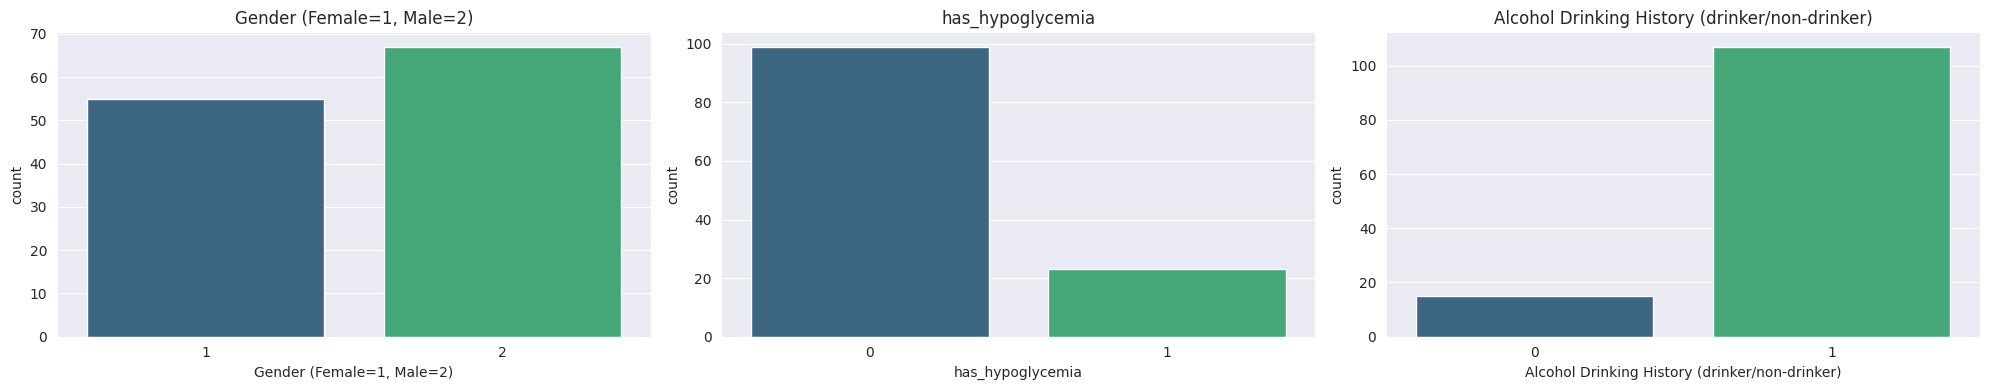

In [26]:
cat_cols_to_fill = [
    'Gender (Female=1, Male=2)', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)'
]

cat_types_combined_df = combined_df[cat_cols_to_fill]

n_cols = 3
n_rows = (len(cat_cols_to_fill) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(cat_cols_to_fill):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(col)
    plt.xticks()

plt.tight_layout()
plt.show()

## Correlation Matrix

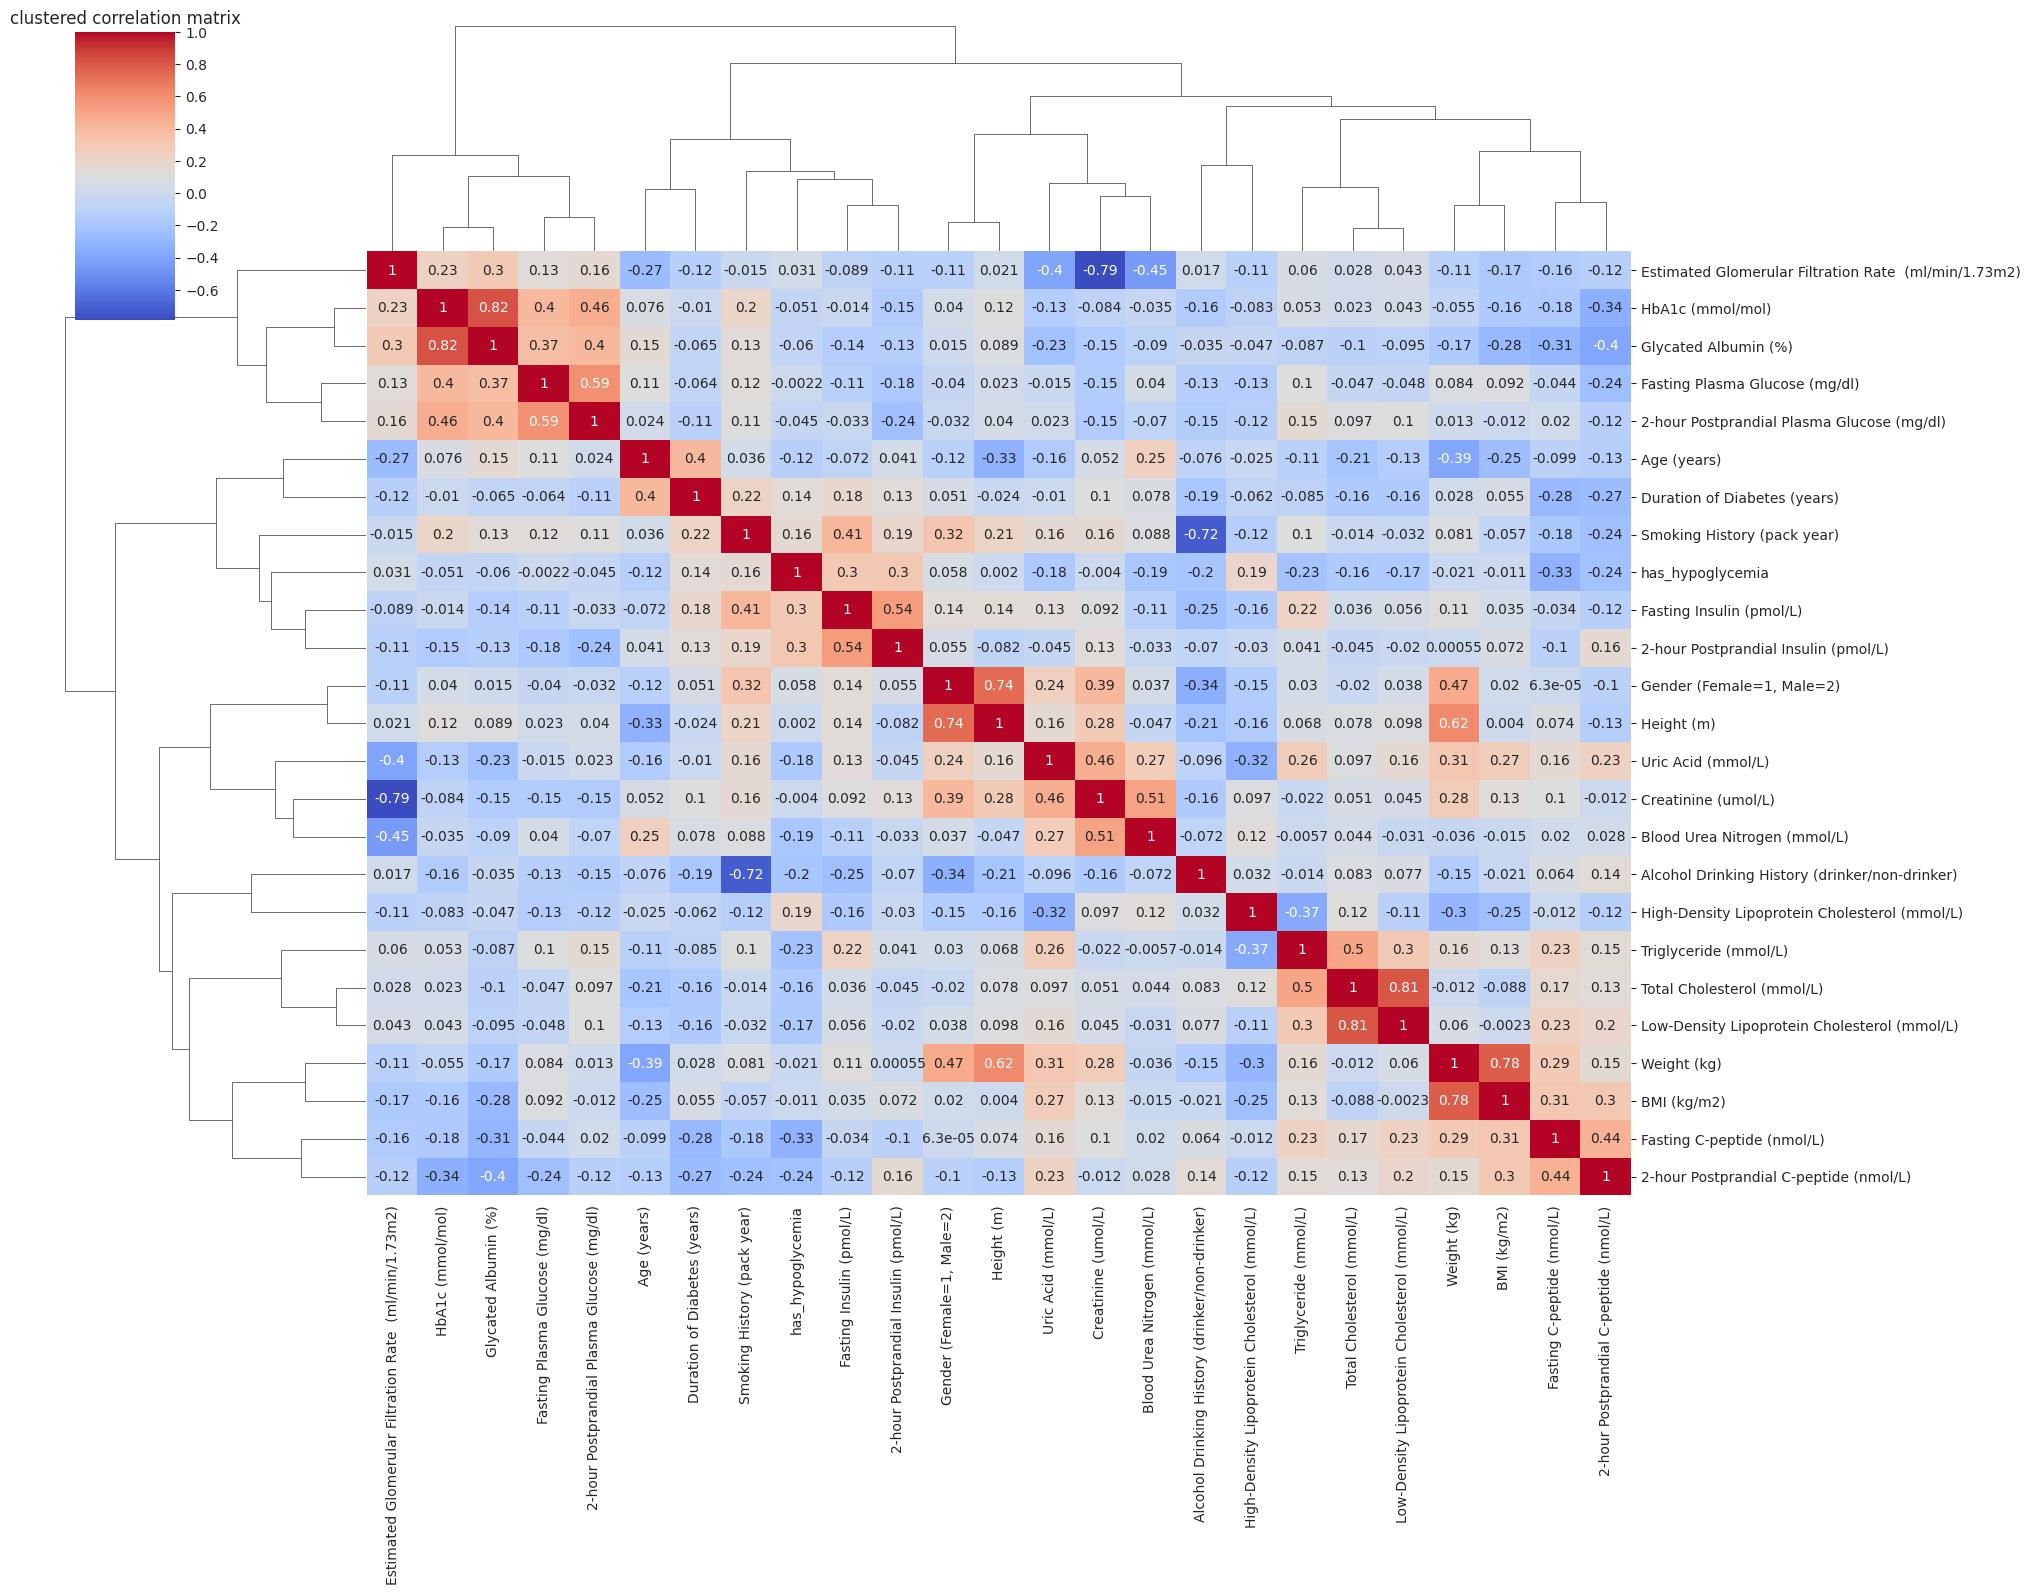

In [38]:
corr_matrix = df.corr(numeric_only=True)

sns.clustermap(corr_matrix,
               cmap='coolwarm',
               figsize=(20, 16),
               annot=True,
               method='ward')  #  (instead of 'ward' we can use 'average', 'single', 'complete')
plt.title("clustered correlation matrix")
plt.show()

# final dataset

In [13]:
folder_path = Path('../data/Shanghai_diabetes_datasets/2_step_finish_dataset/2_step_finish_dataset.csv')
df.to_csv(folder_path)

# PREDICTIVE ANALYSIS

# check if we have all variables

In [40]:
features = [
    'Gender (Female=1, Male=2)', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)', 'Age (years)',
    'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)', '2-hour Postprandial Plasma Glucose (mg/dl)',
    'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)', 'Total Cholesterol (mmol/L)',
    'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)',
    'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
    'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]


def have_all_variables(features, df):
    have = []
    not_have = []

    for feature in features:
        if feature in df.columns:
            have.append(feature)
        else:
            not_have.append(feature)

    print("have:", have)
    print("not have:", not_have)
    print(f"we found in df: {len(have)} don't have: {len(not_have)}")


have_all_variables(features, df)

have: ['Gender (Female=1, Male=2)', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)', 'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)', 'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)', '2-hour Postprandial Plasma Glucose (mg/dl)', 'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)', '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)', 'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)', 'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)', 'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)']
not have: []
we found in df: 25 don't have: 0


# vis-on 'Type of Diabetes' data

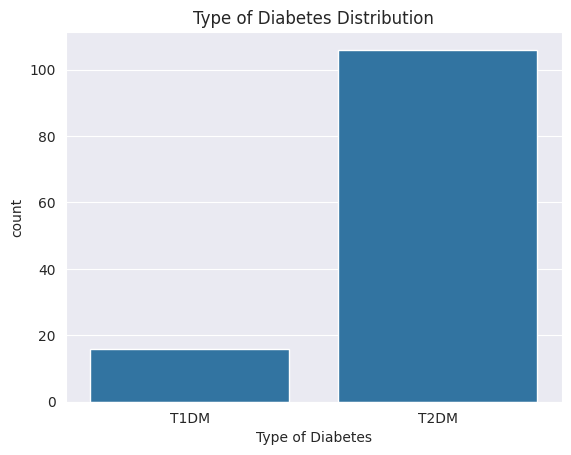

In [41]:
sns.countplot(x='Type of Diabetes', data=df)
plt.title('Type of Diabetes Distribution')
plt.show()

In [59]:
# over = SMOTE(sampling_strategy=0.2)
# under = RandomUnderSampler(sampling_strategy=0.6)

# Define preprocessor

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),
         ['Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
          'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
          '2-hour Postprandial Plasma Glucose (mg/dl)',
          'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
          '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
          'Total Cholesterol (mmol/L)',
          'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)',
          'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
          'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)',
          'Blood Urea Nitrogen (mmol/L)']),
        ('bin', 'passthrough',
         ['Gender (Female=1, Male=2)', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)'
          ])
    ]
)

X = df.drop('Type of Diabetes', axis=1)
y = df['Type of Diabetes']

### Check data after Smote and RandomUnderSampler

In [43]:
df.shape

(122, 27)

In [45]:
pipeline_check = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.2, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=42))
])

X_resampled, y_resampled = pipeline_check.fit_resample(X, y)

print('new class distribution: ', Counter(y_resampled))

new class distribution:  Counter({'T2DM': 42, 'T1DM': 21})


### Visual-on types of diabetes

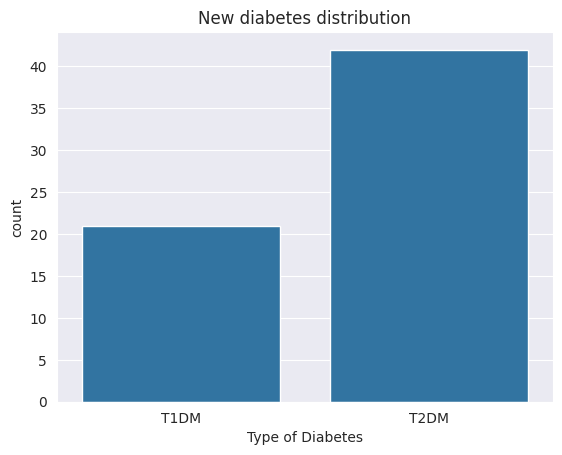

In [46]:
data_check = pd.DataFrame(y_resampled)

sns.countplot(data=data_check, x='Type of Diabetes')
plt.title('New diabetes distribution')
plt.show()

# Create Pipeline / predict and evaluate

## RFC

In [47]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [48]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [49]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

grid_search.fit(X_train, y_train)

print('best parameters: ', grid_search.best_params_)

best parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


In [50]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.96
              precision    recall  f1-score   support

        T1DM       1.00      0.75      0.86         4
        T2DM       0.95      1.00      0.98        21

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25



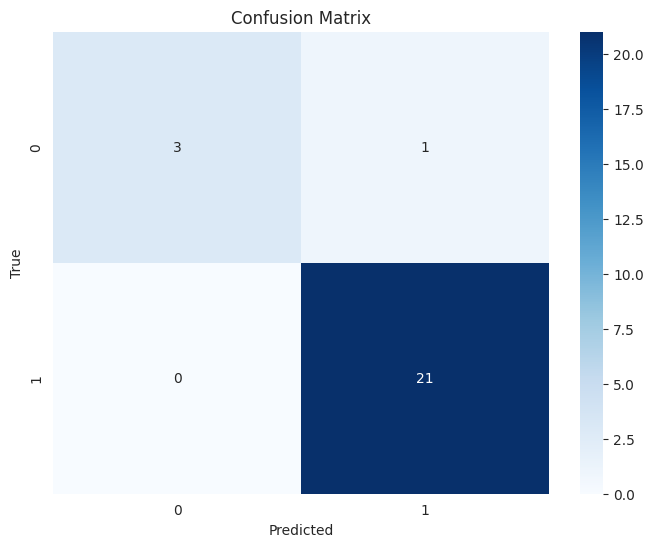

In [51]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### DTC

In [52]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [53]:
param_grid = {
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_depth': [10, 20, 30],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_leaf_nodes': [10, 20, 50],
}

In [54]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': 20, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}


In [55]:
y_pred = grid_search.predict(X_test)
print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.96
              precision    recall  f1-score   support

        T1DM       1.00      0.75      0.86         4
        T2DM       0.95      1.00      0.98        21

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25



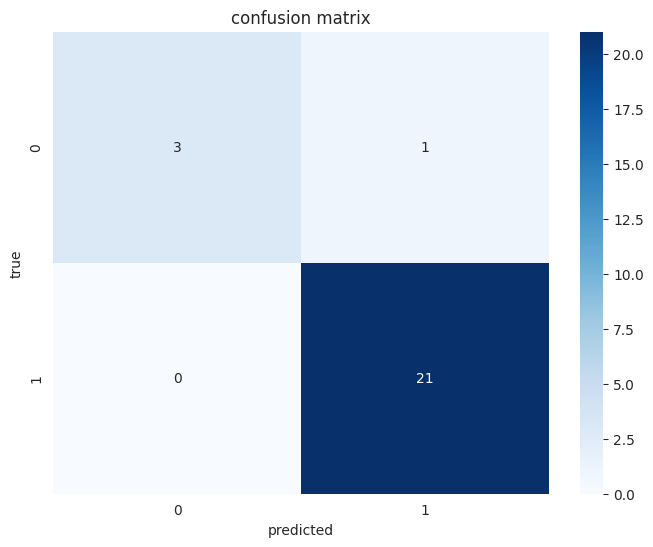

In [56]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

## KNN

In [57]:
clf = Pipeline(## KNN
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]
)

In [58]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2],
    'classifier__weights': ['uniform', 'distance'],
}

In [59]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'uniform'}


In [60]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.88
              precision    recall  f1-score   support

        T1DM       1.00      0.25      0.40         4
        T2DM       0.88      1.00      0.93        21

    accuracy                           0.88        25
   macro avg       0.94      0.62      0.67        25
weighted avg       0.90      0.88      0.85        25



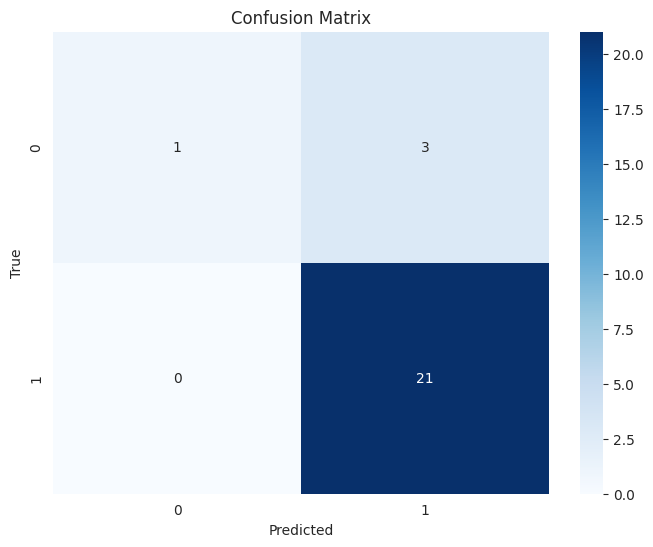

In [61]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## LR

In [62]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]
)

In [64]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [300, 500, 1000]
}

In [65]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print('best parameters', grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenv

best parameters {'classifier__C': 1, 'classifier__max_iter': 300, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenv

In [66]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.96
              precision    recall  f1-score   support

        T1DM       1.00      0.75      0.86         4
        T2DM       0.95      1.00      0.98        21

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25



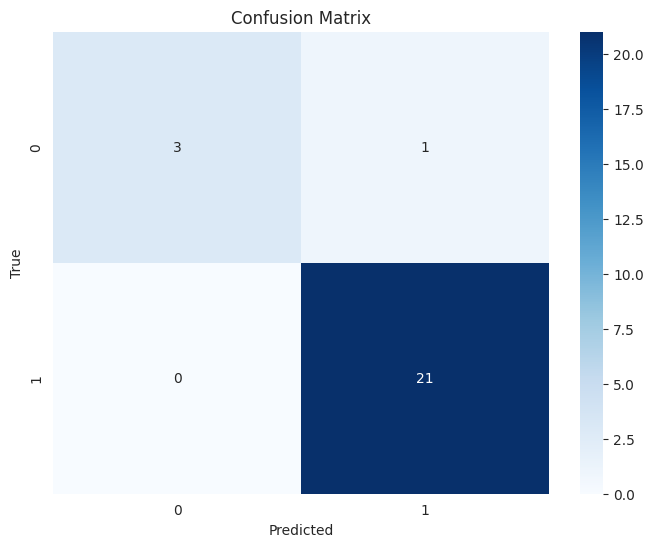

In [67]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [68]:
print(sorted(y.unique()))
# 'T1DM' - 0, 'T2DM' - 1

['T1DM', 'T2DM']


## XGBoost

In [69]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier())
    ]
)

In [70]:
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200],
    'classifier__subsample': [0.8, 1.0],
}

In [71]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


In [72]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.96
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.95      1.00      0.98        21

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25



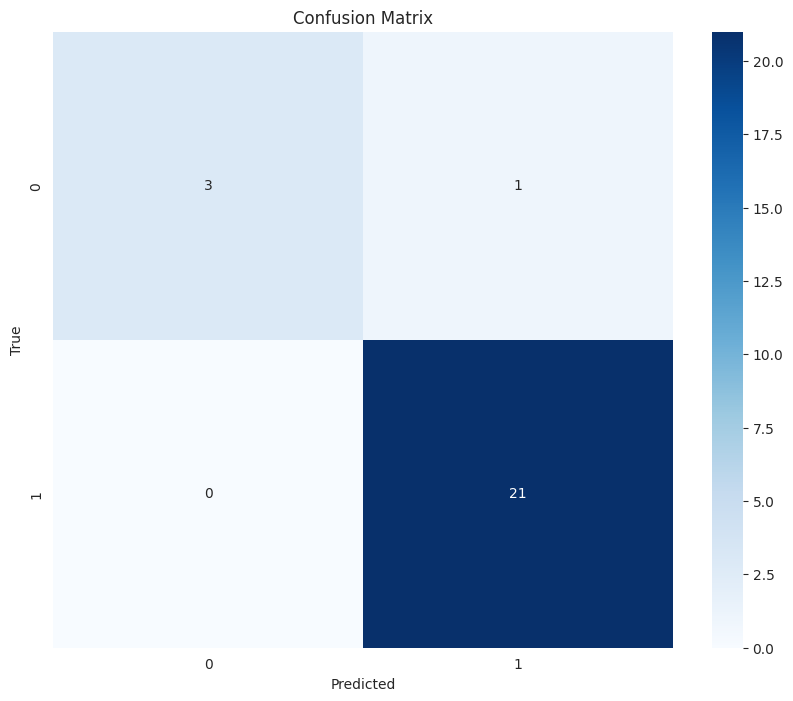

In [73]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Lightgbm

In [74]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(verbose=-1))
    ]
)

In [75]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__num_leaves': [15, 31],
    'classifier__min_child_samples': [10, 20, 30],
}

In [76]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature

best parameters {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_child_samples': 20, 'classifier__n_estimators': 100, 'classifier__num_leaves': 15}


/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [77]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.96
              precision    recall  f1-score   support

        T1DM       1.00      0.75      0.86         4
        T2DM       0.95      1.00      0.98        21

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25



/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


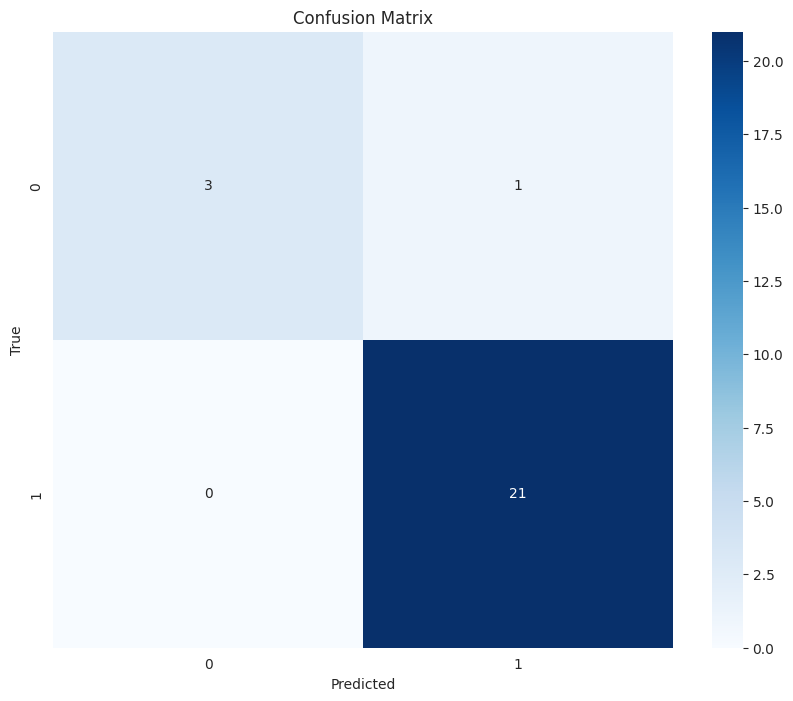

In [78]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()